In [1]:
import numpy
import pandas
import keras
from matplotlib import pyplot
import seaborn
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import StratifiedKFold
import pathlib
from sklearn.metrics import confusion_matrix

%matplotlib inline

In [2]:
# CLASSIFIER PARAMETERS
my_vars = ['petallength', 'petalwidth', 'sepallength', 'sepalwidth'] # 'sepallength', 'sepalwidth', 'petallength', 'petalwidth'
class_col = 'flower'

# TRAINING PARAMETERS
max_hidden_neurons = 4
hidden_neuron_activation = 'tanh' # 'tanh', 'relu', 'sigmoid'
my_metric = 'Accuracy' # 'Precision', 'Recall', 'Accuracy'
min_improvement = 0.01
my_patience = 100
base_max_epoch = 10*my_patience
optimizer_name = 'adam' # 'sgd', 'adam', 'rmsprop'
lr = 0.01
n_k_folds = 5
batch_size = 32
hyperconfig_stat = 'mean' # 'mean', 'median', 'max', 'min'
relevant_features = 2


# CONTROL RANDOMNESS
random_seed = 33

In [3]:
# SET THE RANDOM SEED
keras.utils.set_random_seed(random_seed)

In [4]:
# BUILD PATH TO DATA USING PATHLIB
this_folder = pathlib.Path.cwd()
data_folder = this_folder.parent.parent
path_to_iris = data_folder / 'datasets' / 'iris.data'
my_vars_w_class = my_vars.copy()
my_vars_w_class.append(class_col)
iris = pandas.read_csv(path_to_iris, sep=',', decimal='.')
iris = iris[my_vars_w_class]
iris

,petallength,petalwidth,sepallength,sepalwidth,flower
0,1.4,0.2,5.1,3.5,Iris-setosa
1,1.4,0.2,4.9,3.0,Iris-setosa
2,1.3,0.2,4.7,3.2,Iris-setosa
3,1.5,0.2,4.6,3.1,Iris-setosa
4,1.4,0.2,5.0,3.6,Iris-setosa
...,...,...,...,...,...
145,5.2,2.3,6.7,3.0,Iris-virginica
146,5.0,1.9,6.3,2.5,Iris-virginica
147,5.2,2.0,6.5,3.0,Iris-virginica
148,5.4,2.3,6.2,3.4,Iris-virginica


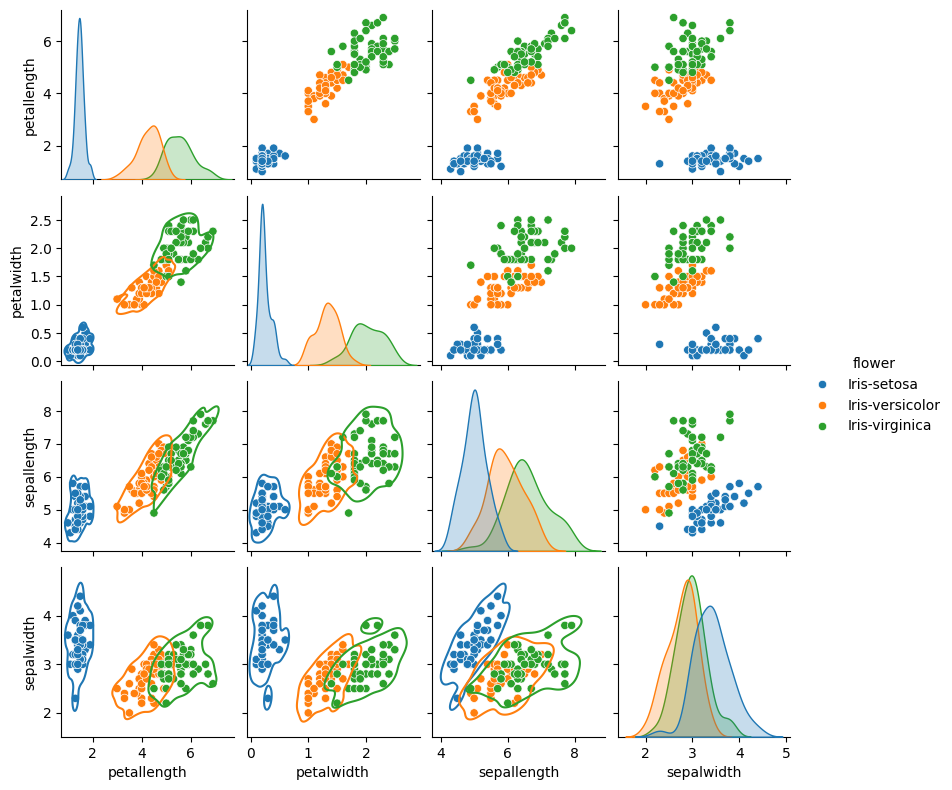

In [5]:
# SCATTER PLOT
_ = g = seaborn.pairplot(iris, hue='flower', height=2, diag_kind='kde')
_ = g.map_lower(seaborn.kdeplot, levels=1, color=".2")

In [6]:
# BASE TRAINING LOOP
my_vars = list(iris.columns[iris.columns != class_col])
df_X = iris[my_vars]
one_hot = OneHotEncoder(sparse_output=False)
df_Y_categorical = iris[[class_col]]
Y_array_categorical = df_Y_categorical.to_numpy()
one_hot.fit(Y_array_categorical)
df_Y = pandas.DataFrame(one_hot.transform(Y_array_categorical))
df_Y.columns = one_hot.categories_
n_classes = df_Y.columns.shape[0]

# PREPARE DATA
X = df_X.to_numpy()
Y = df_Y.to_numpy()

# NORMALIZE VARIABLES
X_scaler = StandardScaler()
X_scaler = X_scaler.fit(X)
X_scaled = X_scaler.transform(X)

# GET STRATIFIED FOLDS
sk_folds = StratifiedKFold(n_splits=n_k_folds)
sk_folds.get_n_splits(X_scaled, Y_array_categorical)

# TRAINING LOOP
result_list = []
for n_neuron in numpy.arange(1, max_hidden_neurons+1):
    ix_fold = 1
    for train_index, validation_index in sk_folds.split(X_scaled, Y_array_categorical):
        X_train, X_val = X_scaled[train_index], X_scaled[validation_index]
        Y_train, Y_val = Y[train_index], Y[validation_index]
        
        # DECLARE NET
        inputs = keras.Input(shape=(len(my_vars), ))
        hidden = keras.layers.Dense(n_neuron, activation=hidden_neuron_activation)(inputs)
        bnorm = keras.layers.BatchNormalization()(hidden)
        outputs = keras.layers.Dense(n_classes, activation='softmax')(bnorm)
        model_name = f'{optimizer_name.upper()}-{hidden_neuron_activation.upper()}-N{n_neuron}F{ix_fold}'
        my_net = keras.Model(inputs=inputs, outputs=outputs, name=model_name)
        val_metric_name = 'val_{}'.format(my_metric)

        match optimizer_name:
            case 'sgd':
                optimizer = keras.optimizers.SGD(learning_rate=lr)
            case 'adam':
                optimizer = keras.optimizers.Adam(learning_rate=lr)
            case 'rmsprop':
                optimizer = keras.optimizers.RMSprop(learning_rate=lr)
            case _:
                raise ValueError(f'Optimizer {optimizer_name} not recognized')

        my_net.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=[my_metric])
        es_loss = keras.callbacks.EarlyStopping(monitor='val_loss', patience=my_patience, restore_best_weights=True)
        es_metric = keras.callbacks.EarlyStopping(monitor=my_metric, mode='max', patience=my_patience, min_delta=min_improvement, restore_best_weights=True)
        
        # FIT
        history = my_net.fit(X_train, Y_train, validation_data=(X_val, Y_val), batch_size=X_train.shape[0], epochs=base_max_epoch, verbose=0, callbacks=[es_loss, es_metric])
        
        # UNPACK TRAINING RESULTS
        model_loss = history.history['loss'][-1]
        model_val_loss = history.history['val_loss'][-1]
        metric_val = history.history[my_metric][-1]
        val_metric_val = history.history[val_metric_name][-1]
        n_epochs = len(history.history['val_loss'])
        result_dict = {'model_name': model_name,
                       'optimizer_name' : optimizer_name,
                       'neurons': n_neuron,
                       'fold': ix_fold,
                       'loss': model_loss,
                       'val_loss': model_val_loss,
                       my_metric: metric_val,
                       val_metric_name: val_metric_val,
                       'epochs': n_epochs,
                       'net': my_net,
                       'history': history}
        result_list.append(result_dict)
        print(f'{model_name} > epochs: {n_epochs} loss: {model_loss:.2f} val_loss: {model_val_loss:.2f} {my_metric}: {100.0*metric_val:.0f}% {val_metric_name}: {100.0*val_metric_val:.0f}%')
        ix_fold += 1 

ADAM-TANH-N1F1 > epochs: 259 loss: 0.13 val_loss: 0.27 Accuracy: 98% val_Accuracy: 90%
ADAM-TANH-N1F2 > epochs: 278 loss: 0.10 val_loss: 0.55 Accuracy: 97% val_Accuracy: 73%
ADAM-TANH-N1F3 > epochs: 242 loss: 0.14 val_loss: 0.25 Accuracy: 98% val_Accuracy: 97%
ADAM-TANH-N1F4 > epochs: 325 loss: 0.08 val_loss: 0.29 Accuracy: 97% val_Accuracy: 93%
ADAM-TANH-N1F5 > epochs: 289 loss: 0.09 val_loss: 0.16 Accuracy: 98% val_Accuracy: 97%
ADAM-TANH-N2F1 > epochs: 178 loss: 0.08 val_loss: 0.06 Accuracy: 96% val_Accuracy: 97%
ADAM-TANH-N2F2 > epochs: 137 loss: 0.07 val_loss: 0.54 Accuracy: 98% val_Accuracy: 73%
ADAM-TANH-N2F3 > epochs: 183 loss: 0.04 val_loss: 0.10 Accuracy: 98% val_Accuracy: 97%
ADAM-TANH-N2F4 > epochs: 300 loss: 0.02 val_loss: 0.14 Accuracy: 100% val_Accuracy: 93%
ADAM-TANH-N2F5 > epochs: 339 loss: 0.10 val_loss: 0.05 Accuracy: 98% val_Accuracy: 100%
ADAM-TANH-N3F1 > epochs: 204 loss: 0.09 val_loss: 0.07 Accuracy: 97% val_Accuracy: 97%
ADAM-TANH-N3F2 > epochs: 196 loss: 0.06 v

In [7]:
df_results = pandas.DataFrame(result_list)

df_results.sort_values(by=[f'val_{my_metric}', my_metric, 'neurons'], ascending=[False, False, True])

,model_name,optimizer_name,neurons,fold,loss,val_loss,Accuracy,val_Accuracy,epochs,net,history
12,ADAM-TANH-N3F3,adam,3,3,0.051324,0.116751,0.983333,1.000000,208,"<Functional name=ADAM-TANH-N3F3, built=True>",<keras.src.callbacks.history.History object at...
14,ADAM-TANH-N3F5,adam,3,5,0.055379,0.016321,0.983333,1.000000,232,"<Functional name=ADAM-TANH-N3F5, built=True>",<keras.src.callbacks.history.History object at...
19,ADAM-TANH-N4F5,adam,4,5,0.055313,0.013541,0.983333,1.000000,255,"<Functional name=ADAM-TANH-N4F5, built=True>",<keras.src.callbacks.history.History object at...
9,ADAM-TANH-N2F5,adam,2,5,0.095145,0.048308,0.975000,1.000000,339,"<Functional name=ADAM-TANH-N2F5, built=True>",<keras.src.callbacks.history.History object at...
7,ADAM-TANH-N2F3,adam,2,3,0.037623,0.098365,0.983333,0.966667,183,"<Functional name=ADAM-TANH-N2F3, built=True>",<keras.src.callbacks.history.History object at...
15,ADAM-TANH-N4F1,adam,4,1,0.057374,0.074530,0.983333,0.966667,202,"<Functional name=ADAM-TANH-N4F1, built=True>",<keras.src.callbacks.history.History object at...
17,ADAM-TANH-N4F3,adam,4,3,0.036737,0.096692,0.983333,0.966667,233,"<Functional name=ADAM-TANH-N4F3, built=True>",<keras.src.callbacks.history.History object at...
2,ADAM-TANH-N1F3,adam,1,3,0.140138,0.249542,0.975000,0.966667,242,"<Functional name=ADAM-TANH-N1F3, built=True>",<keras.src.callbacks.history.History object at...
4,ADAM-TANH-N1F5,adam,1,5,0.088139,0.163772,0.975000,0.966667,289,"<Functional name=ADAM-TANH-N1F5, built=True>",<keras.src.callbacks.history.History object at...
11,ADAM-TANH-N3F2,adam,3,2,0.056558,0.087514,0.975000,0.966667,196,"<Functional name=ADAM-TANH-N3F2, built=True>",<keras.src.callbacks.history.History object at...


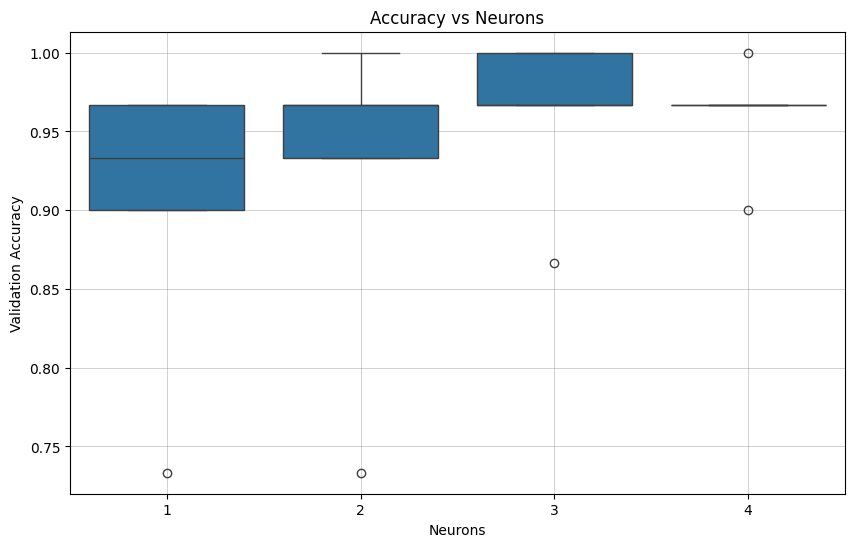

In [8]:
# BOXPLOT VAL METRIC VS NEURONS
fig = pyplot.figure(figsize=(10, 6))
ax = fig.add_subplot(111)
_ = seaborn.boxplot(x='neurons', y=f'val_{my_metric}', data=df_results, ax=ax)
_ = ax.set_title(f'{my_metric} vs Neurons')
_ = ax.set_xlabel('Neurons')
_ = ax.set_ylabel(f'Validation {my_metric}')
_ = ax.grid(which='major', linestyle='-', linewidth='0.5', color='gray', alpha=0.5)


In [9]:
# AGGREGATE BY NEURONS AND OPTIMIZER
df_results_agg = df_results.groupby(['neurons', 'optimizer_name']).agg({f'val_{my_metric}': ['mean', 'std', 'min', 'max']}).reset_index()
df_results_agg.columns = ['neurons', 'optimizer_name', 'mean', 'std', 'min', 'max']
df_results_agg = df_results_agg.sort_values(by=[hyperconfig_stat, 'neurons'], ascending=[False, True])
df_results_agg

,neurons,optimizer_name,mean,std,min,max
2,3,adam,0.96,0.054772,0.866667,1.000000
3,4,adam,0.96,0.036515,0.900000,1.000000
1,2,adam,0.92,0.106979,0.733333,1.000000
0,1,adam,0.90,0.097183,0.733333,0.966667


In [10]:
best_hyperconfig = df_results_agg.iloc[0]
best_neurons = int(best_hyperconfig['neurons'])
best_optimizer_name = best_hyperconfig['optimizer_name']
best_hyperconfig

neurons                  3
optimizer_name        adam
mean                  0.96
std               0.054772
min               0.866667
max                    1.0
Name: 2, dtype: object

In [11]:
best_rows = df_results[(df_results.neurons == best_neurons) & (df_results.optimizer_name == best_optimizer_name)]
best_net_name = best_rows['model_name'].values[0]
best_optimizer_name = best_rows['optimizer_name'].values[0]
best_net = best_rows['net'].values[0]
best_neurons = best_rows['neurons'].values[0]
best_metric = best_rows[my_metric].values[0]
best_metric_val = best_rows[val_metric_name].values[0]
best_history = best_rows['history'].values[0]
best_epochs = best_rows['epochs'].values[0]

best_rows


,model_name,optimizer_name,neurons,fold,loss,val_loss,Accuracy,val_Accuracy,epochs,net,history
10,ADAM-TANH-N3F1,adam,3,1,0.086125,0.066076,0.966667,0.966667,204,"<Functional name=ADAM-TANH-N3F1, built=True>",<keras.src.callbacks.history.History object at...
11,ADAM-TANH-N3F2,adam,3,2,0.056558,0.087514,0.975000,0.966667,196,"<Functional name=ADAM-TANH-N3F2, built=True>",<keras.src.callbacks.history.History object at...
12,ADAM-TANH-N3F3,adam,3,3,0.051324,0.116751,0.983333,1.000000,208,"<Functional name=ADAM-TANH-N3F3, built=True>",<keras.src.callbacks.history.History object at...
13,ADAM-TANH-N3F4,adam,3,4,0.079542,0.365388,1.000000,0.866667,233,"<Functional name=ADAM-TANH-N3F4, built=True>",<keras.src.callbacks.history.History object at...
14,ADAM-TANH-N3F5,adam,3,5,0.055379,0.016321,0.983333,1.000000,232,"<Functional name=ADAM-TANH-N3F5, built=True>",<keras.src.callbacks.history.History object at...


In [12]:
# CALCULATE VARIABLE RELEVANCE USING THE BEST NET
Y_est = best_net.predict(X_scaled, verbose=0)
relevance_dict = {}
for feature in my_vars:
    X_relevance = numpy.copy(X_scaled)
    X_relevance[:, df_X.columns == feature] = 0.0
    Y_est_relevance = best_net.predict(X_relevance, verbose=0)
    Y_relevance = (Y_est - Y_est_relevance)**2
    feature_relevance = Y_relevance.sum()/Y_relevance.shape[0]
    relevance_dict[feature] = feature_relevance
s_relevance = pandas.Series(relevance_dict)
s_relevance_norm = s_relevance/s_relevance.max()
s_relevance_norm = s_relevance_norm.sort_values(ascending=False).head(relevant_features)
selected_features = list(s_relevance_norm.index.values)
selected_relevance = list(100.0*s_relevance_norm.values)
df_relevance = pandas.DataFrame({'feature': selected_features, 'relevance': selected_relevance})

In [13]:
df_relevance

,feature,relevance
0,petalwidth,100.000000
1,petallength,18.838167


In [14]:
# RETRAIN THE NET USING ONLY THE RELEVANT FEATURES
X_relevant = df_X[selected_features].to_numpy()

# GET STRATIFIED FOLDS
sk_folds = StratifiedKFold(n_splits=n_k_folds)
sk_folds.get_n_splits(X_relevant, Y_array_categorical)

# TRAINING LOOP
result_list = []
for n_layers in numpy.arange(1, best_neurons+1):
    for n_neuron in numpy.arange(1, best_neurons+1):
        ix_fold = 1
        for train_index, validation_index in sk_folds.split(X_relevant, Y_array_categorical):
            X_train, X_val = X_relevant[train_index], X_relevant[validation_index]
            Y_train, Y_val = Y[train_index], Y[validation_index]
            
            # DECLARE NET
            inputs = keras.Input(shape=(len(selected_features), ))
            hidden = keras.layers.Dense(n_neuron, activation=hidden_neuron_activation)(inputs)
            hidden = keras.layers.BatchNormalization()(hidden)
            if n_layers > 1:
                for _ in range(n_layers-1):
                    hidden = keras.layers.Dense(n_layers, activation=hidden_neuron_activation)(hidden)
                    hidden = keras.layers.BatchNormalization()(hidden)

            outputs = keras.layers.Dense(n_classes, activation='softmax')(hidden)
            model_name = f'{optimizer_name.upper()}-{hidden_neuron_activation.upper()}-L{n_layers}N{n_neuron}F{ix_fold}'
            my_net = keras.Model(inputs=inputs, outputs=outputs, name=model_name)
            val_metric_name = 'val_{}'.format(my_metric)

            match optimizer_name:
                case 'sgd':
                    optimizer = keras.optimizers.SGD(learning_rate=lr)
                case 'adam':
                    optimizer = keras.optimizers.Adam(learning_rate=lr)
                case 'rmsprop':
                    optimizer = keras.optimizers.RMSprop(learning_rate=lr)
                case _:
                    raise ValueError(f'Optimizer {optimizer_name} not recognized')

            my_net.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=[my_metric])
            es_loss = keras.callbacks.EarlyStopping(monitor='val_loss', patience=my_patience, restore_best_weights=True)
            es_metric = keras.callbacks.EarlyStopping(monitor=my_metric, mode='max', patience=my_patience, min_delta=min_improvement, restore_best_weights=True)
            
            # FIT
            history = my_net.fit(X_train, Y_train, validation_data=(X_val, Y_val), batch_size=X_train.shape[0], epochs=best_epochs, verbose=0, callbacks=[es_loss, es_metric])
            
            # UNPACK TRAINING RESULTS
            model_loss = history.history['loss'][-1]
            model_val_loss = history.history['val_loss'][-1]
            metric_val = history.history[my_metric][-1]
            val_metric_val = history.history[val_metric_name][-1]
            n_epochs = len(history.history['val_loss'])
            result_dict = {'model_name': model_name,
                            'optimizer_name' : optimizer_name,
                            'layers' : n_layers,
                            'neurons': n_neuron,
                            'fold': ix_fold,
                            'loss': model_loss,
                            'val_loss': model_val_loss,
                            my_metric: metric_val,
                            val_metric_name: val_metric_val,
                            'epochs': n_epochs,
                            'net': my_net,
                            'history': history}
            result_list.append(result_dict)
            print(f'{model_name} > epochs: {n_epochs} loss: {model_loss:.2f} val_loss: {model_val_loss:.2f} {my_metric}: {100.0*metric_val:.0f}% {val_metric_name}: {100.0*val_metric_val:.0f}%')
            ix_fold += 1

ADAM-TANH-L1N1F1 > epochs: 194 loss: 0.18 val_loss: 1.09 Accuracy: 96% val_Accuracy: 57%
ADAM-TANH-L1N1F2 > epochs: 170 loss: 0.23 val_loss: 0.55 Accuracy: 96% val_Accuracy: 73%
ADAM-TANH-L1N1F3 > epochs: 204 loss: 0.23 val_loss: 1.06 Accuracy: 96% val_Accuracy: 50%
ADAM-TANH-L1N1F4 > epochs: 177 loss: 1.09 val_loss: 1.11 Accuracy: 34% val_Accuracy: 33%
ADAM-TANH-L1N1F5 > epochs: 101 loss: 0.49 val_loss: 0.77 Accuracy: 42% val_Accuracy: 53%
ADAM-TANH-L1N2F1 > epochs: 189 loss: 0.18 val_loss: 0.40 Accuracy: 96% val_Accuracy: 80%
ADAM-TANH-L1N2F2 > epochs: 165 loss: 0.11 val_loss: 0.71 Accuracy: 96% val_Accuracy: 73%
ADAM-TANH-L1N2F3 > epochs: 182 loss: 0.07 val_loss: 0.72 Accuracy: 97% val_Accuracy: 77%
ADAM-TANH-L1N2F4 > epochs: 155 loss: 0.11 val_loss: 0.76 Accuracy: 97% val_Accuracy: 73%
ADAM-TANH-L1N2F5 > epochs: 168 loss: 0.17 val_loss: 1.57 Accuracy: 95% val_Accuracy: 67%
ADAM-TANH-L1N3F1 > epochs: 129 loss: 0.08 val_loss: 1.51 Accuracy: 96% val_Accuracy: 67%
ADAM-TANH-L1N3F2 > ep

In [15]:
df_final_results = pandas.DataFrame(result_list)

In [16]:
# AGGREGATE BY NEURONS AND OPTIMIZER
df_final_results_agg = df_final_results.groupby(['neurons', 'optimizer_name']).agg({f'val_{my_metric}': ['mean', 'std', 'min', 'max']}).reset_index()
df_final_results_agg.columns = ['neurons', 'optimizer_name', 'mean', 'std', 'min', 'max']
df_final_results_agg = df_final_results_agg.sort_values(by=[hyperconfig_stat, 'neurons'], ascending=[False, True])
df_final_results_agg

,neurons,optimizer_name,mean,std,min,max
2,3,adam,0.621667,0.130798,0.333333,0.800000
1,2,adam,0.588333,0.183301,0.333333,0.933333
0,1,adam,0.555000,0.149179,0.333333,0.766667


In [17]:
best_final_hyperconfig = df_final_results_agg.iloc[0]
best_final_neurons = int(best_final_hyperconfig['neurons'])
best_final_optimizer_name = best_final_hyperconfig['optimizer_name']
best_final_hyperconfig

neurons                  3
optimizer_name        adam
mean              0.621667
std               0.130798
min               0.333333
max                    0.8
Name: 2, dtype: object

In [18]:
best_final_rows = df_final_results[(df_final_results.neurons == best_final_neurons) & (df_final_results.optimizer_name == best_final_optimizer_name)]
best_final_net_name = best_final_rows['model_name'].values[0]
best_final_optimizer_name = best_final_rows['optimizer_name'].values[0]
best_final_net = best_final_rows['net'].values[0]
best_final_neurons = best_final_rows['neurons'].values[0]
best_final_metric = best_final_rows[my_metric].values[0]
best_final_metric_val = best_final_rows[val_metric_name].values[0]
best_final_history = best_final_rows['history'].values[0]
best_final_epochs = best_final_rows['epochs'].values[0]

best_final_rows

,model_name,optimizer_name,layers,neurons,fold,loss,val_loss,Accuracy,val_Accuracy,epochs,net,history
10,ADAM-TANH-L1N3F1,adam,1,3,1,0.084662,1.508563,0.958333,0.666667,129,"<Functional name=ADAM-TANH-L1N3F1, built=True>",<keras.src.callbacks.history.History object at...
11,ADAM-TANH-L1N3F2,adam,1,3,2,0.149506,1.144432,0.958333,0.600000,101,"<Functional name=ADAM-TANH-L1N3F2, built=True>",<keras.src.callbacks.history.History object at...
12,ADAM-TANH-L1N3F3,adam,1,3,3,0.164010,1.378073,0.966667,0.633333,149,"<Functional name=ADAM-TANH-L1N3F3, built=True>",<keras.src.callbacks.history.History object at...
13,ADAM-TANH-L1N3F4,adam,1,3,4,0.125319,0.709173,0.975000,0.766667,156,"<Functional name=ADAM-TANH-L1N3F4, built=True>",<keras.src.callbacks.history.History object at...
14,ADAM-TANH-L1N3F5,adam,1,3,5,0.161386,0.522376,0.950000,0.766667,146,"<Functional name=ADAM-TANH-L1N3F5, built=True>",<keras.src.callbacks.history.History object at...
25,ADAM-TANH-L2N3F1,adam,2,3,1,0.107309,1.679693,0.966667,0.633333,126,"<Functional name=ADAM-TANH-L2N3F1, built=True>",<keras.src.callbacks.history.History object at...
26,ADAM-TANH-L2N3F2,adam,2,3,2,0.061096,4.627812,0.983333,0.333333,169,"<Functional name=ADAM-TANH-L2N3F2, built=True>",<keras.src.callbacks.history.History object at...
27,ADAM-TANH-L2N3F3,adam,2,3,3,0.072515,0.670901,0.966667,0.800000,204,"<Functional name=ADAM-TANH-L2N3F3, built=True>",<keras.src.callbacks.history.History object at...
28,ADAM-TANH-L2N3F4,adam,2,3,4,0.071755,0.631389,0.966667,0.700000,159,"<Functional name=ADAM-TANH-L2N3F4, built=True>",<keras.src.callbacks.history.History object at...
29,ADAM-TANH-L2N3F5,adam,2,3,5,0.148257,1.266867,0.941667,0.666667,107,"<Functional name=ADAM-TANH-L2N3F5, built=True>",<keras.src.callbacks.history.History object at...


In [19]:
if best_final_metric_val > best_metric_val:
    selected_net = best_final_net
    selected_net_name = best_final_net_name
    selected_neurons = best_final_neurons
    selected_optimizer_name = best_final_optimizer_name
    selected_metric = best_final_metric
    selected_metric_val = best_final_metric_val
    selected_history = best_final_history
    selected_epochs = best_final_epochs
    selected_df_results = df_final_results
    final_is_better = True
    print('Final model is better than the original model')
else:
    selected_net = best_net
    selected_net_name = best_net_name
    selected_neurons = best_neurons
    selected_optimizer_name = best_optimizer_name
    selected_metric = best_metric
    selected_metric_val = best_metric_val
    selected_history = best_history
    selected_epochs = best_epochs
    selected_df_results = df_results
    final_is_better = False
    print('Original model is better than the final model')

Original model is better than the final model


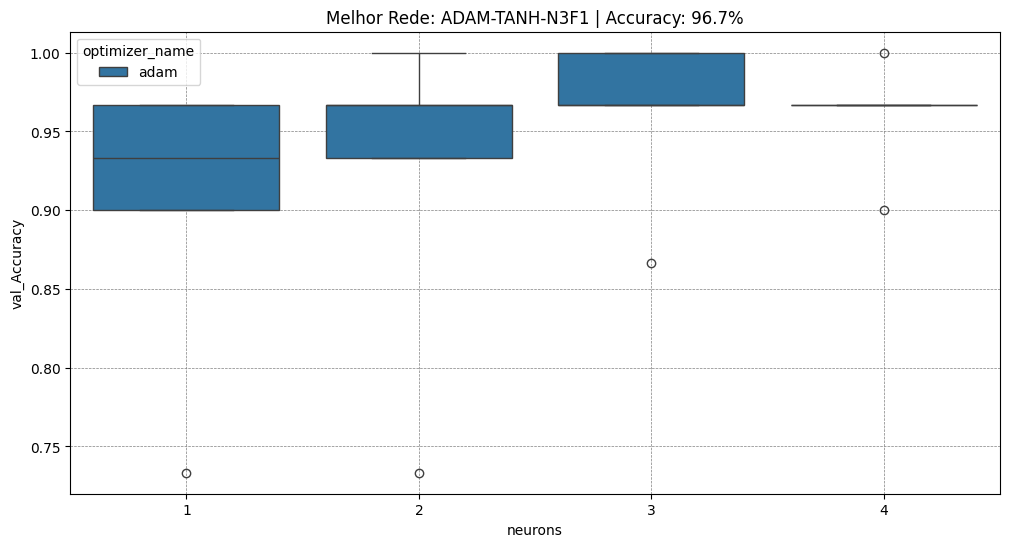

In [20]:
# DRAW A BOXPLOT OF THE RESULTS, GROUPING BY NEURONS AND OPTIMIZER
fig = pyplot.figure(figsize=(12, 6))
ax = fig.add_subplot(111)
_ = seaborn.boxplot(data=selected_df_results, x='neurons', y=f'val_{my_metric}', hue='optimizer_name', ax=ax)
_ = ax.set_title(f'Melhor Rede: {selected_net_name} | {my_metric}: {100.0*selected_metric_val:.1f}%')
_ = ax.grid(which='major', linestyle='--', linewidth='0.5', color='gray')

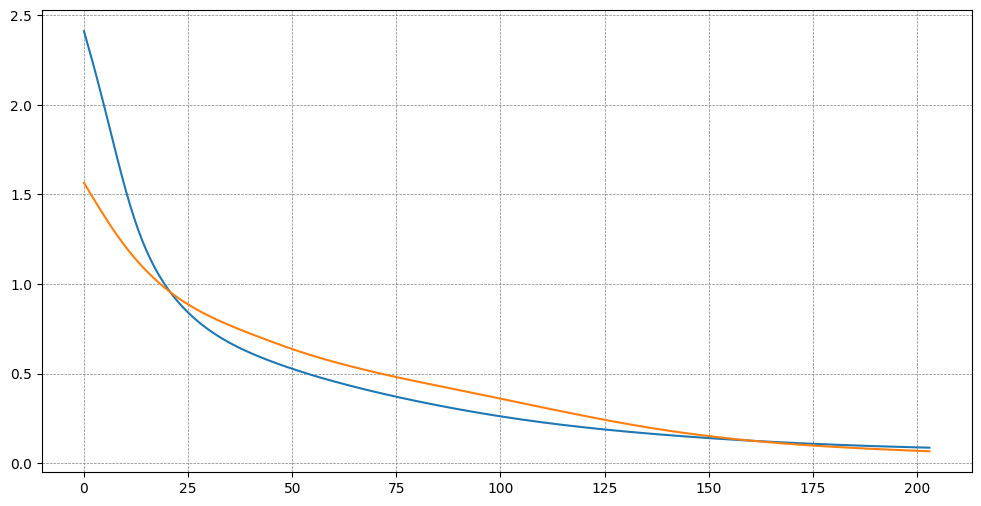

In [21]:
# PLOT TRAINING HISTORY
fig = pyplot.figure(figsize=(12, 6))
ax = fig.add_subplot(111)
_ = ax.plot(selected_history.history['loss'], label='loss')
_ = ax.plot(selected_history.history['val_loss'], label='val_loss')
_ = ax.grid(which='major', linestyle='--', linewidth='0.5', color='gray')

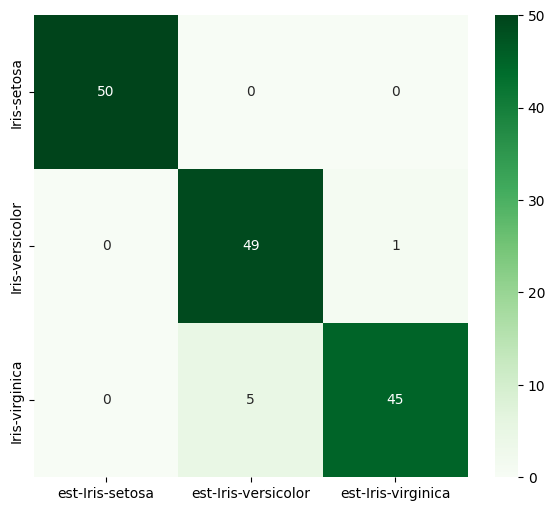

In [22]:
my_classes = [x[0] for x in df_Y.columns.values]
if final_is_better:
    Y_est = selected_net.predict(X_scaled[:, df_X.columns.isin(selected_features)], verbose=0)
else:
    Y_est = selected_net.predict(X_scaled, verbose=0)
Y_class_est = numpy.array([df_Y.columns[x][0] for x in numpy.argmax(Y_est, axis=1)])
my_conf = confusion_matrix(df_Y_categorical[class_col].to_numpy(), Y_class_est, labels=my_classes)
df_conf = pandas.DataFrame(my_conf, index=my_classes, columns=['est-{}'.format(x) for x in my_classes])
# df_conf = pandas.DataFrame(100.0*my_conf/my_conf.sum(axis=0), index=['est-{}'.format(x) for x in my_classes], columns=my_classes)

fig, ax = pyplot.subplots(figsize=(7,6)) 
_ = seaborn.heatmap(df_conf, cmap="Greens", ax=ax, annot=True, fmt='.0f')